In [15]:
import equipy as eq

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, log_loss
import matplotlib.pyplot as plt

from folktables import ACSDataSource, ACSEmployment
from equipy.fairness import MultiWasserstein
from equipy.metrics import unfairness, performance

# Regression problem

As the regression problem we choose the prediction of a person's total income in state California using the US Census data.

## Dataset

We use the `folktables` python library to download dataset and choose specific filters like year, horizon and states etc. 

In [46]:
survey_year = "2018"
horizon = "1-Year"
survey = "person"
states = ["CA"]  # change to e.g. ["CA","TX","NY"] or all states if you want (can be slow)

data_source = ACSDataSource(survey_year=survey_year, horizon=horizon, survey=survey)
acs = data_source.get_data(states=states, download=True)

In [47]:
print("(num_rows, num_variables):", acs.shape)

(num_rows, num_variables): (378817, 286)


In [48]:
# ------------------------------------------
# 2) Build "ACSIncome-regression-like" task
#    Predict log(total income) = log(PINCP)
# ------------------------------------------
feature_cols = [
    "AGEP",  # age
    "COW",   # class of worker
    "SCHL",  # education
    "MAR",   # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # usual hours worked per week
    "SEX",   # sex
    "RAC1P", # race
]
target_col = "PINCP"  # total person's income

To make data more consistent, we need to apply some filters on data. For this type of regression, we predict the total income only for people that are
- Older than 16 years
- Work per week more than 1 hour
- Have positive income

In [49]:
# Typical filters used around ACSIncome variants in the literature:
# - working-age adults
# - worked at least some hours
# - positive income floor
acs = acs.loc[
    (acs["AGEP"] > 16) &
    (acs["WKHP"] > 1) &
    (acs[target_col] > 0)
].copy()

In [78]:
X = acs[feature_cols].copy()
y = np.log(acs[target_col].to_numpy(dtype=np.float64))

In [79]:
sensitive_cols = ["SEX", "RAC1P"] # sensitive attributes for fairness analysis
S = acs[sensitive_cols].copy()

Split the dataset on Train, Test and Calibration

In [80]:
# -----------------------------------------
# 3) Split train / calib / test
#    (calib labels not needed for EquiPy)
# -----------------------------------------
seed = 0
X_train, X_tmp, y_train, y_tmp, S_train, S_tmp = train_test_split(
    X, y, S, test_size=0.5, random_state=seed
)
X_calib, X_test, y_calib, y_test, S_calib, S_test = train_test_split(
    X_tmp, y_tmp, S_tmp, test_size=0.20, random_state=seed
)

In [81]:
X_train.shape, X_calib.shape, X_test.shape

((97735, 10), (78188, 10), (19548, 10))

In [82]:
S_calib.value_counts()

SEX  RAC1P
1    1        26023
2    1        22409
     6         6643
1    6         6430
     8         5117
2    8         3966
     2         1725
1    9         1684
2    9         1619
1    2         1610
     3          282
2    3          244
1    7          123
2    7          121
1    5           99
2    5           87
     4            4
1    4            2
Name: count, dtype: int64

Notice that among our groups with fixed gender and nationality there are very small groups, like males with nationality 4 is only 1 person in Calibration Data.
For the proper fairness analysis, we need much larger groups, for this we are going to filter some very small national groups and mark them as OTHERS or put -1 integer value.

In [83]:
col = "RAC1P"
min_count = 800  # choose threshold

# decide which race codes to keep using TRAIN only
vc = X_train[col].value_counts()
keep = set(vc[vc >= min_count].index)

def relabel_col(df: pd.DataFrame, col: str, keep: set, other=10):
    df = df.copy()
    df[col] = df[col].where(df[col].isin(keep), other)
    return df

X_train2 = relabel_col(X_train, col, keep)
X_calib2 = relabel_col(X_calib, col, keep)
X_test2  = relabel_col(X_test,  col, keep)

# if you also have S_* extracted separately, relabel them too (same keep set)
S_train2 = relabel_col(S_train, col, keep)
S_calib2 = relabel_col(S_calib, col, keep)
S_test2  = relabel_col(S_test,  col, keep)

Now there are only 6 nationalities, the "1", "2", "6", "8", "9" and others which is "10"

In [84]:
print("Train:\n", X_train2[col].value_counts())
print("Calib:\n", X_calib2[col].value_counts())
print("Test:\n",  X_test2[col].value_counts())
missing = set(X_test2[col].unique()) - set(X_calib2[col].unique())
print("Missing in calib (should be empty):", missing)

Train:
 RAC1P
1     60297
6     16369
8     11440
2      4335
9      4106
10     1188
Name: count, dtype: int64
Calib:
 RAC1P
1     48432
6     13073
8      9083
2      3335
9      3303
10      962
Name: count, dtype: int64
Test:
 RAC1P
1     12099
6      3252
8      2276
2       881
9       796
10      244
Name: count, dtype: int64
Missing in calib (should be empty): set()


## Regression

For solving the regression problem, we are going to use **LightGBM** or Light Gradient Boosting Method, we can use any model, this I choose because it appropriate for the current data.

In [85]:
# ---------------------------------------------------
# 4) Train LightGBM (as in the paper-style snippet)
# ---------------------------------------------------
# NOTE: put your tuned hyperparameters here (paper says "optimized_parameters")
optimized_parameters = {
    "objective": "regression",
    "metric": "l2",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "seed": seed,
    "verbosity": 1,
    "force_col_wise": True,  # often faster on wide-ish tabular data
    "num_threads": 32,        # set to your physical cores
}


In [86]:
categorical_cols = ["COW", "SCHL", "MAR", "OCCP", "POBP", "RELP", "SEX", "RAC1P"]

In [87]:
train_data = lgb.Dataset(
    data=X_train2,
    label=y_train,
    categorical_feature=categorical_cols,
    free_raw_data=False,
)

model = lgb.train(
    train_set=train_data,
    params=optimized_parameters,
    num_boost_round=500,
)

predictions_calib = model.predict(X_calib2)
predictions_test = model.predict(X_test2)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 97735, number of used features: 10
[LightGBM] [Info] Start training from score 10.482323


## Fairness analysis

We trained our model and now have the outputs for the test data and calibration data. We are going to use the calibration data to train our new fair model using Wasserstein barycenters. For this, we use the `equipy` library

In [88]:
wasserstein = MultiWasserstein(sigma=1e-3)
wasserstein.fit(y=predictions_calib, sensitive_features=S_calib2)

Unfrairness metric just shows the discrepancy how the probability of y is different among different sensitive parameters.

In [89]:
from equipy.metrics import unfairness
unfairness(y=predictions_test, sensitive_features=S_test2) # Unfairness of original model

np.float64(1.021628280179506)

Now we build new fair predictions using our fairness model `wasserstein`

In [90]:
predictions_test_fair = wasserstein.transform(y=predictions_test, sensitive_features=S_test2)

New unfairness value for the fair output by our model, we should observe decrease of fairness

In [91]:
unfairness(y=predictions_test_fair, sensitive_features=S_test2)

np.float64(0.488997248317121)

Also, our new fair model is an suboptimal model, it should give more error on loss function between true y.

In [92]:
from equipy.metrics import performance
performance(y_test, predictions_test)

0.5724298730453824

In [93]:
performance(y_test, predictions_test_fair)

0.6498196515693954

In the `equipy` library we can fix a parameter $\alpha \in [0, 1]$ which gives us tradeoff between fairness and model accuracy, heree we build a plot over different $\alpha$ values

In [94]:
# Sweep epsilon to get a risk/unfairness curve
# epsilon is a list (one per sensitive attribute) for MultiWasserstein
eps_grid = np.linspace(0.0, 1.0, 11)

rows = []
for e in eps_grid:
    eps = [float(e)] * len(sensitive_cols)
    y_fair = wasserstein.transform(
        y=predictions_test,
        sensitive_features=S_test2,
        epsilon=eps,
    )

    # "risk" / performance (use your paper's metric if different)
    mse = mean_squared_error(y_test, y_fair)
    # EquiPy unfairness summary (works for multi-sensitive)
    unf = unfairness(y=y_fair, sensitive_features=S_test2)

    rows.append({"epsilon": e, "mse": mse, "unfairness": unf})

results = pd.DataFrame(rows)
print(results)

    epsilon       mse  unfairness
0       0.0  0.649820    0.488997
1       0.1  0.635643    0.504816
2       0.2  0.622905    0.508508
3       0.3  0.611621    0.497169
4       0.4  0.601724    0.507237
5       0.5  0.593277    0.559425
6       0.6  0.586234    0.645039
7       0.7  0.580656    0.737971
8       0.8  0.576474    0.836388
9       0.9  0.573737    0.937721
10      1.0  0.572430    1.021628


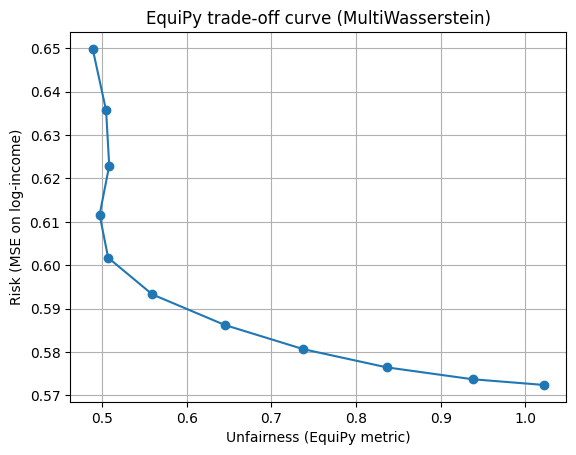


Baseline:
{'mse': 0.5724298730453824, 'unfairness': np.float64(2.4261688102975363)}


In [95]:
# -------------------------------------------------------
# 6) Simple plot: unfairness vs risk (MSE)
# -------------------------------------------------------
plt.figure()
plt.plot(results["unfairness"], results["mse"], marker="o")
plt.xlabel("Unfairness (EquiPy metric)")
plt.ylabel("Risk (MSE on log-income)")
plt.title("EquiPy trade-off curve (MultiWasserstein)")
plt.grid(True)
plt.show()

# Baseline check (no post-processing):
baseline_mse = mean_squared_error(y_test, predictions_test)
baseline_unf = unfairness(y=predictions_test, sensitive_features=S_test)
print("\nBaseline:")
print({"mse": baseline_mse, "unfairness": baseline_unf})

In [96]:
from sinkhorn_fairness import monge_maps_fit, apply_fair_maps_to_test_logits, create_marginal_masks, apply_map_1d, hist_on_grid

In [97]:
maps, grid = monge_maps_fit(
    S_calib=S_calib2,
    p_calib=predictions_calib,
    sinkhorn_reg=1e-4,
    sinkhorn_tol=1e-8,
    sinkhorn_maxiter=20_000,
    pad=1e-6,
)

In [98]:
p_fair_sink = apply_fair_maps_to_test_logits(
  p_test=predictions_test,
  S_test=S_test2,
  grid=grid,
  maps=maps,
)

In [99]:
unfairness(y=p_fair_sink, sensitive_features=S_test2)

np.float64(0.4718166576524476)

In [100]:
performance(y_test, p_fair_sink)

0.6491799854918043

In [101]:
eps_grid = np.linspace(0.0, 1.0, 11)

rows = []
for e in eps_grid:
    eps = [float(e)] * len(sensitive_cols)
    y_fair = apply_fair_maps_to_test_logits(
      p_test=predictions_test,
      S_test=S_test2,
      grid=grid,
      maps=maps,
      alpha=eps[0]
    )

    # "risk" / performance (use your paper's metric if different)
    mse = mean_squared_error(y_test, y_fair)
    # EquiPy unfairness summary (works for multi-sensitive)
    unf = unfairness(y=y_fair, sensitive_features=S_test2)

    rows.append({"epsilon": e, "mse": mse, "unfairness": unf})

results_sink = pd.DataFrame(rows)
print(results_sink)

    epsilon       mse  unfairness
0       0.0  0.649180    0.471817
1       0.1  0.635103    0.467340
2       0.2  0.622449    0.481349
3       0.3  0.611217    0.489238
4       0.4  0.601408    0.516944
5       0.5  0.593022    0.589264
6       0.6  0.586058    0.662534
7       0.7  0.580517    0.756897
8       0.8  0.576399    0.845783
9       0.9  0.573703    0.939079
10      1.0  0.572430    1.021628


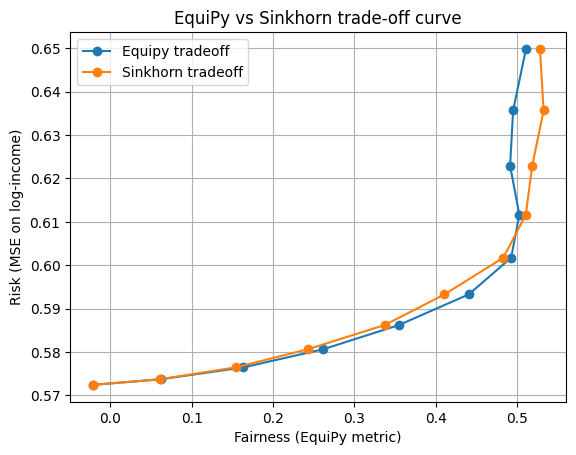


Baseline:
{'mse': 0.5724298730453824, 'unfairness': np.float64(2.4261688102975363)}


In [102]:
# -------------------------------------------------------
# 6) Simple plot: unfairness vs risk (MSE)
# -------------------------------------------------------
plt.figure()
plt.plot(1 - results["unfairness"], results["mse"], marker="o", label="Equipy tradeoff")
plt.plot(1 - results_sink["unfairness"], results["mse"], marker="o", label="Sinkhorn tradeoff")
plt.xlabel("Fairness (EquiPy metric)")
plt.ylabel("Risk (MSE on log-income)")
plt.title("EquiPy vs Sinkhorn trade-off curve")
plt.grid(True)
plt.legend()
plt.show()

# Baseline check (no post-processing):
baseline_mse = mean_squared_error(y_test, predictions_test)
baseline_unf = unfairness(y=predictions_test, sensitive_features=S_test)
print("\nBaseline:")
print({"mse": baseline_mse, "unfairness": baseline_unf})

## Other metrics to compute fairness
- Kolmogorov-Smirnov
- Wasserstein-1

In [14]:
def _iter_modalities(sensitive_df: pd.DataFrame, y: np.ndarray):
    for col in sensitive_df.columns:
        sens = sensitive_df[col]
        modalities = list(pd.unique(sens))
        yield col, sens, modalities

def unfairness_ks(y: np.ndarray, sensitive_df: pd.DataFrame) -> float:
    """
    Sum over sensitive columns of max over modalities of KS distance
    between overall y and modality y_g.
    """
    y = np.asarray(y, dtype=float)

    total = 0.0
    y_sorted = np.sort(y)
    n = y_sorted.size

    for _, sens, modalities in _iter_modalities(sensitive_df, y):
        max_ks = 0.0
        for mod in modalities:
            yg = np.asarray(y[sens == mod], dtype=float)
            if yg.size == 0:
                continue
            yg_sorted = np.sort(yg)

            # Evaluate both CDFs on the union of sample points
            grid = np.unique(np.concatenate([y_sorted, yg_sorted]))
            Fy = np.searchsorted(y_sorted, grid, side="right") / n
            Fg = np.searchsorted(yg_sorted, grid, side="right") / yg_sorted.size
            ks = np.max(np.abs(Fy - Fg))
            max_ks = max(max_ks, float(ks))
        total += max_ks

    return float(total)

def _w1_1d_between_samples(a: np.ndarray, b: np.ndarray) -> float:
    """
    1D Wasserstein-1 between empirical distributions with equal weights.
    Uses a common grid of sample points and integrates |CDF diff|.
    """
    a = np.sort(np.asarray(a, dtype=float))
    b = np.sort(np.asarray(b, dtype=float))
    if a.size == 0 or b.size == 0:
        return np.nan

    grid = np.unique(np.concatenate([a, b]))
    Fa = np.searchsorted(a, grid, side="right") / a.size
    Fb = np.searchsorted(b, grid, side="right") / b.size
    # integrate |Fa - Fb| over grid (Riemann sum)
    dx = np.diff(grid)
    if dx.size == 0:
        return 0.0
    mid = (np.abs(Fa - Fb)[:-1] + np.abs(Fa - Fb)[1:]) / 2.0
    return float(np.sum(mid * dx))

def unfairness_w1(y: np.ndarray, sensitive_df: pd.DataFrame) -> float:
    """
    Sum over sensitive columns of max over modalities of W1 distance
    between overall y and modality y_g.
    """
    y = np.asarray(y, dtype=float)

    total = 0.0
    for _, sens, modalities in _iter_modalities(sensitive_df, y):
        max_w1 = 0.0
        for mod in modalities:
            yg = y[sens == mod]
            if yg.size == 0:
                continue
            d = _w1_1d_between_samples(y, yg)
            if np.isfinite(d):
                max_w1 = max(max_w1, d)
        total += max_w1
    return float(total)



In [104]:
unfairness_ks(p_fair_sink, S_test2), unfairness_w1(p_fair_sink, S_test2)

(0.04583794062553859, 0.07018250657313146)

In [116]:
unfairness_ks(predictions_test_fair, S_test2), unfairness_w1(predictions_test_fair, S_test2)

(0.04685592086938911, 0.06146706728424885)

In [117]:
unfairness_ks(predictions_test, S_test2), unfairness_w1(predictions_test, S_test2)

(0.3421559490841567, 0.5755677441495701)

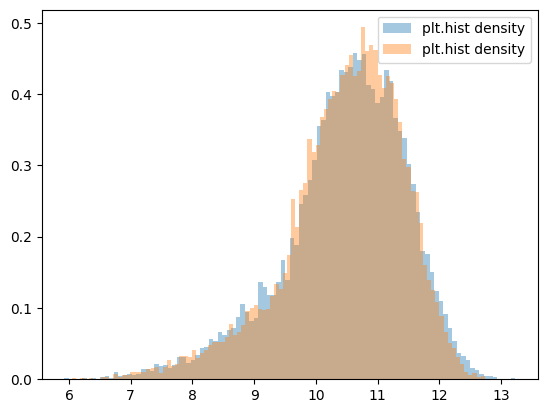

In [ ]:
plt.figure()
# plt.hist(predictions_test_fair, bins=100, density=True, alpha=0.4, label="plt.hist density")
plt.hist(predictions_test, bins=100, density=True, alpha=0.4, label="plt.hist density")
plt.hist(p_fair_sink, bins=100, density=True, alpha=0.4, label="plt.hist density")
plt.legend()
plt.show()

# Classification problem

In [57]:
seed = 0
states = ["CA", "TX", "FL"]  # or more states

data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_source.get_data(states=states, download=True)

# Folktables API: features, label, group = ACSEmployment.df_to_numpy(...)
# We'll use df_to_pandas so we keep column names easily. :contentReference[oaicite:1]{index=1}
X_df, y_ser, _ = ACSEmployment.df_to_pandas(acs_data)  # y is 0/1 employed label (ESR task) :contentReference[oaicite:2]{index=2}

# Choose your sensitive attributes (must be columns available in X_df)
sensitive_cols = ["SEX", "RAC1P"]
S_df = X_df[sensitive_cols].astype(str).copy()

# Joint stratification key to avoid missing modalities in calib/test
# joint = S_df.apply(lambda r: "_".join(r.values), axis=1)

In [58]:
X = X_df
y = y_ser.to_numpy()          # this should be 0/1
S = S_df

X_train, X_tmp, y_train, y_tmp, S_train, S_tmp = train_test_split(
    X, y, S, test_size=0.40, random_state=seed
)
X_calib, X_test, y_calib, y_test, S_calib, S_test = train_test_split(
    X_tmp, y_tmp, S_tmp, test_size=0.50, random_state=seed,
)
print(np.unique(y_train), np.unique(y_test))

[False  True] [False  True]


In [59]:
col = "RAC1P"

def coerce_to_int(series: pd.Series) -> pd.Series:
    # handles strings like "1.0", "2", 2.0, etc.
    s = pd.to_numeric(series, errors="coerce")
    if s.isna().any():
        # If you don't expect NaNs, raise to catch bad rows early
        bad = series[s.isna()].head(10)
        raise ValueError(f"Found non-numeric values in column. Examples:\n{bad}")
    return s.round().astype("int64")

for df in (X_train, X_calib, X_test, S_train, S_calib, S_test):
    df[col] = coerce_to_int(df[col])
    df["SEX"] = coerce_to_int(df["SEX"])

min_count = 3000
vc = X_train[col].value_counts()
keep = set(vc[vc >= min_count].index)
print("keep:", keep)

def relabel_col(df: pd.DataFrame, col: str, keep: set, other=10):
    df = df.copy()
    df[col] = df[col].where(df[col].isin(keep), other).astype("int64")
    return df

X_train2 = relabel_col(X_train, col, keep)
X_calib2 = relabel_col(X_calib, col, keep)
X_test2  = relabel_col(X_test,  col, keep)

S_train2 = relabel_col(S_train, col, keep)
S_calib2 = relabel_col(S_calib, col, keep)
S_test2  = relabel_col(S_test,  col, keep)

print(S_calib2.value_counts())

keep: {1, 2, 6, 8, 9}
SEX  RAC1P
2    1        61203
1    1        59213
2    6         8135
1    6         7148
2    2         7005
1    2         6679
     8         6320
2    8         6242
1    9         3195
2    9         3139
     10         770
1    10         766
Name: count, dtype: int64


In [60]:
# 3) Train LightGBM (binary)
# -----------------------------
optimized_parameters = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "seed": seed,
    "verbosity": -1,
    "force_col_wise": True,  # often faster on wide-ish tabular data
    "num_threads": 32,        # set to your physical cores
}

train_data = lgb.Dataset(X_train2, label=y_train, free_raw_data=False)
model = lgb.train(train_set=train_data, params=optimized_parameters, num_boost_round=500)

/home/druban/miniconda3/envs/py313/lib/python3.13/site-packages/lightgbm/basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


In [61]:
# Scores = P(Y=1|x)
p_calib = model.predict(X_calib2)
p_test  = model.predict(X_test2)


# -----------------------------
# 4) EquiPy post-processing
# -----------------------------
wasserstein = MultiWasserstein(sigma=1e-4)
wasserstein.fit(y=p_calib, sensitive_features=S_calib2)

In [62]:
p_test.max()

np.float64(0.9785217030901547)

In [63]:
from sklearn.metrics import log_loss
print(f"Error={performance(y_test, p_test, metric=log_loss)}, Unfairness={unfairness(p_test, sensitive_features=S_test2)}")

Error=0.37255886296464913, Unfairness=0.3501074339006276


In [64]:
p_test_fair = wasserstein.transform(y=p_test, sensitive_features=S_test2)
print(f"Error={performance(y_test, p_test_fair, metric=log_loss)}, Unfairness={unfairness(p_test_fair, sensitive_features=S_test2)}")

Error=0.3856556739047444, Unfairness=0.02959811694097142


In [65]:
eps_grid = np.linspace(0.0, 1.0, 11)

rows = []
for e in eps_grid:
    eps = [float(e)] * len(sensitive_cols)
    y_fair = wasserstein.transform(
        y=p_test,
        sensitive_features=S_test2,
        epsilon=eps,
    )

    # "risk" / performance (use your paper's metric if different)
    mse = mean_squared_error(y_test, y_fair)
    # EquiPy unfairness summary (works for multi-sensitive)
    unf = unfairness(y=y_fair, sensitive_features=S_test2)

    rows.append({"epsilon": e, "mse": mse, "unfairness": unf})

results = pd.DataFrame(rows)
print(results)

    epsilon       mse  unfairness
0       0.0  0.125233    0.029598
1       0.1  0.124411    0.053282
2       0.2  0.123694    0.082355
3       0.3  0.123076    0.111401
4       0.4  0.122549    0.143131
5       0.5  0.122110    0.175114
6       0.6  0.121758    0.208704
7       0.7  0.121488    0.243901
8       0.8  0.121298    0.279208
9       0.9  0.121186    0.314456
10      1.0  0.121149    0.350107


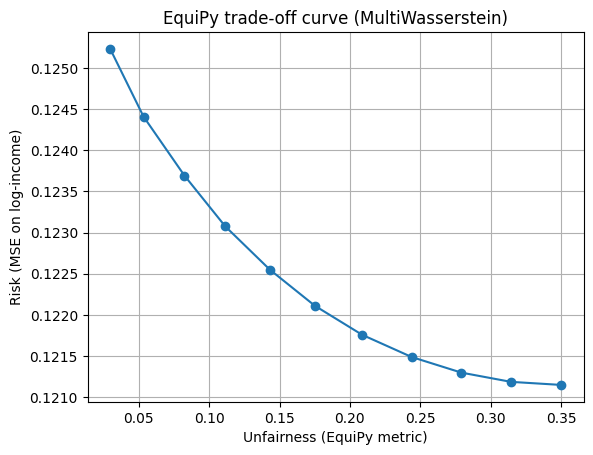


Baseline:
{'mse': 0.12114883533039326, 'unfairness': np.float64(0.8691691309659516)}


In [66]:
# -------------------------------------------------------
# 6) Simple plot: unfairness vs risk (MSE)
# -------------------------------------------------------
plt.figure()
plt.plot(results["unfairness"], results["mse"], marker="o")
plt.xlabel("Unfairness (EquiPy metric)")
plt.ylabel("Risk (MSE on log-income)")
plt.title("EquiPy trade-off curve (MultiWasserstein)")
plt.grid(True)
plt.show()

# Baseline check (no post-processing):
baseline_mse = mean_squared_error(y_test, p_test)
baseline_unf = unfairness(y=p_test, sensitive_features=S_test)
print("\nBaseline:")
print({"mse": baseline_mse, "unfairness": baseline_unf})

In [69]:
from sinkhorn_fairness import monge_maps_fit, apply_fair_maps_to_test_logits

In [82]:
def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log1p(-p)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z_calib = logit(p_calib)
z_test  = logit(p_test)

# fit OT maps on logits
maps, grid = monge_maps_fit(
    S_calib=S_calib2,
    p_calib=z_calib,
    sinkhorn_reg=1e-4,        # logits often need larger reg
    sinkhorn_tol=1e-8,
    sinkhorn_maxiter=50_000,
    pad=1e-5,
    cost='l1'
)

z_fair = apply_fair_maps_to_test_logits(
    p_test=z_test,
    S_test=S_test2,
    grid=grid,
    maps=maps,
)

p_fair_sink = sigmoid(z_fair)      # back to probabilities
# p_fair_sink = z_fair

In [83]:
unfairness_ks(p_test_fair, S_test2), unfairness_w1(p_test_fair, S_test2), float(unfairness(p_test_fair, S_test2))

(0.02333152096715113, 0.008394601901052085, 0.02959811694097142)

In [84]:
unfairness_ks(p_fair_sink, S_test2), unfairness_w1(p_fair_sink, S_test2), float(unfairness(p_fair_sink, S_test2))

(0.21210527014817138, 0.05363615085752967, 0.21307911035786078)

In [85]:
unfairness_ks(p_test, S_test2), unfairness_w1(p_test, S_test2), float(unfairness(p_test, S_test2))

(0.3081056938815755, 0.11904977089048459, 0.3501074339006276)

In [74]:
eps_grid = np.linspace(0.0, 1.0, 11)

rows = []
for e in eps_grid:
    eps = [float(e)] * len(sensitive_cols)
    z_calib = logit(p_calib)
    z_test  = logit(p_test)

    # fit OT maps on logits
    maps, grid = monge_maps_fit(
        S_calib=S_calib2,
        p_calib=z_calib,
        sinkhorn_reg=1e-4,        # logits often need larger reg
        sinkhorn_tol=1e-8,
        sinkhorn_maxiter=50_000,
        pad=1e-5,
        )

    z_fair = apply_fair_maps_to_test_logits(
        p_test=z_test,
        S_test=S_test2,
        grid=grid,
        maps=maps,
        alpha=e,
    )

    y_fair = sigmoid(z_fair)

    # "risk" / performance (use your paper's metric if different)
    mse = mean_squared_error(y_test, y_fair)
    # EquiPy unfairness summary (works for multi-sensitive)
    unf = unfairness(y=y_fair, sensitive_features=S_test2)

    rows.append({"epsilon": e, "mse": mse, "unfairness": unf})

results_sink = pd.DataFrame(rows)
print(results_sink)

    epsilon       mse  unfairness
0       0.0  0.125528    0.057278
1       0.1  0.124653    0.110623
2       0.2  0.123903    0.159760
3       0.3  0.123255    0.194490
4       0.4  0.122698    0.226692
5       0.5  0.122228    0.256583
6       0.6  0.121844    0.280823
7       0.7  0.121545    0.300416
8       0.8  0.121329    0.319051
9       0.9  0.121197    0.334003
10      1.0  0.121149    0.350107


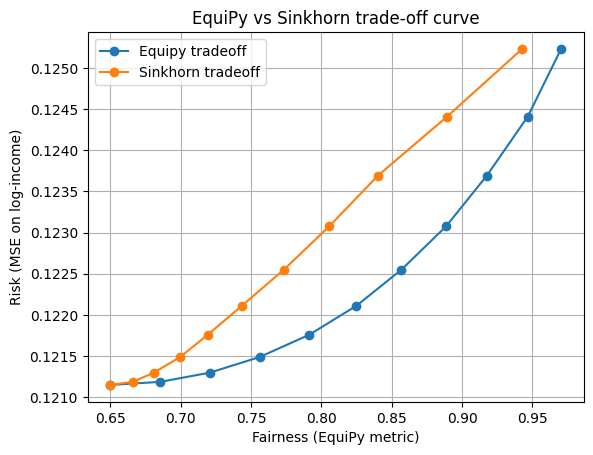


Baseline:
{'mse': 0.12114883533039326, 'Fairness': np.float64(0.8691691309659516)}


In [75]:
# -------------------------------------------------------
# 6) Simple plot: unfairness vs risk (MSE)
# -------------------------------------------------------
plt.figure()
plt.plot(1 - results["unfairness"], results["mse"], marker="o", label="Equipy tradeoff")
plt.plot(1 - results_sink["unfairness"], results["mse"], marker="o", label="Sinkhorn tradeoff")
plt.xlabel("Fairness (EquiPy metric)")
plt.ylabel("Risk (MSE on log-income)")
plt.title("EquiPy vs Sinkhorn trade-off curve")
plt.grid(True)
plt.legend()
plt.show()

# Baseline check (no post-processing):
baseline_mse = mean_squared_error(y_test, p_test)
baseline_unf = unfairness(y=p_test, sensitive_features=S_test)
print("\nBaseline:")
print({"mse": baseline_mse, "Fairness": baseline_unf})